# Active subspaces w/ Autograd in TensorFlow
If we are given a scalar-valued function $f:\mathbb{R}^m \supset \mathcal{X} \rightarrow \mathbb{R}:x \mapsto f(x)$ over some compact domain $\mathcal{X}$ with measureable gradient, then consider the symmetric postivie semi-definite matrix $C \in \mathbb{R}^{m \times m}$ defined as
$$
C = \int_{\mathcal{X}} \nabla f(x) \nabla f(x)^T d\mu \quad \text{or} \quad C_{ij} = \int_{\mathcal{X}}\frac{\partial f}{\partial x_i}\frac{\partial f}{\partial x_j}d\mu \quad \text{for all} \quad i,j = 1, \dots, m.
$$

For all intensive purposes, the integral measure is typically written with a non-negative probability density $d\mu = \rho(x)dx$ , $\rho:\mathcal{X} \rightarrow \mathbb{R}_+$, such that $\rho$ is uniform
$$
\rho(x) = \begin{cases}
1, x \in \mathcal{X}\\
0, x \notin \mathcal{X}
\end{cases}
$$
and $\mathcal{X}$ is typically some hypercube, $\mathcal{X} = [x_{\ell}, x_u]^m$, constructed from the tensor product of upper and lower bounds, $x_{\ell} \leq x \leq x_{u}$, on the entries of $x \in \mathbb{R}^m$. The goal is to approximate the real non-negative eigendecomposition $C = W\Lambda W^T$ where $W \in O(m)$ and $\Lambda = \text{diag}(\lambda_1,\dots,\lambda_m)$ such that
$$
\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_r > \lambda_{r+1} = \dots = \lambda_m = 0
$$
for $\text{rank}(C) = r$. Partitioning $W$ into $m$ orthonormal eigenvectors $w_i \in \mathbb{R}^m$ representing the columns, $W = [w_1 \dots w_m]$, we can simplify $w_i^TCw_i$ to obtain an expression for the eigenvalues,
$$
\lambda_i = \int_{\mathcal{X}}(w_i^T \nabla f(x))^2 d\mu.
$$
Reinterpreting the integral by definition of the expectation, $\mathbb{E}[x] = \int_{\mathcal{X}}xd\mu$, the eigenvalues can be interpreted as the mean-squared directional derivative of $f$ in the direction of $w_i$. Precisely, recall that the directional derivative is defined
$$
D_tf[w_i] = \lim_{t \rightarrow 0} \frac{f(x + tw_i) - f(x)}{t}. 
$$
Substituting a Taylor series expansion around $x$, this simplifies as
$$
D_tf[w_i] = w_i^T \nabla f(x)
$$
and we obtain $\lambda_i = \mathbb{E}[(D_tf[w_i])^2]$--the $i^{th}$ eigenvalue is the mean squared directional derivative in the direction of the $i^{th}$ eigenvector.
Thus, the inherent ordering of the eigenpairs $(\lambda_i, w_i)$, indicate directions which change the function $f$ the most, on average, up to the $r+1,\dots,m$ directions which do not change the function at all. Naturally, if the trailing eigenvalues are small as opposed to zero, then the function does not change very much over those trailing directions--this can be made precise by deriving an upper bound for a ridge approximation $f(x) \approx h(W_r^Tx)$ where $W_r = [w_1, \dots, w_r] \in \mathbb{R}^{m \times r}$ for a very particular choice of norm and construction of $h$ [Constantine, (2015)]. Either way, the subspace spanned by the columns of $W$, i.e., $\text{Range}(W)$, encodes a change of coordinates with an inherent ordering of the basis (directions) which change the funciton the most, on average, so that we may consider sweeps and projections over these new important directions. These subsequent sweeps and projections will enable visualizations of the function in the fewer $r \leq m$ directions.

The basic idea of this notebook is to approximate the eigendecomposition of this high-dimensional integral and make some visualizations to supplement our intuition.

As in all cases, we begin by importing the appropriate modules (this demo utilizes TensorFlow v2: "pip install tensorflow")...

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Now, let's define the domain by picking the dimension $m$ and taking a finite number of random samples $N$ which we will draw from uniform $\rho$ defined over a hypercube $\mathcal{X} = [-1,1]^m$ to approximate $C$ using Monte-Carlo. Additionally, let's pick the true rank of the matrix $C$ as an example and look at the resulting decay in the eigenvalues (the trailing eigenvalues should be on the order of the square root of machine precision). In other words, we'll construct a toy function which only changes along a few $r$ directions and we want to verify that our approximation of the eigenspaces of $C$ are accurate and provides a useful set of coordinates (a linear combination of the original parameters) which change $f$ more, on average.

In [25]:
# set the number of parameters (voltages)
m = 10
# set the number of random samples
N = 5000
# sample a [-1,1] hypercube
X = 2. * tf.random.uniform((N, m)) - 1.
# pick dummy rank of C (r <= m)
r = 4

Next, we define a "ridge function" as our toy function which takes in a matrix of data representing the random draws of the $m$-dimensional parameters, placed in a data-matrix "X", and is parameterized by $r$-directions in a matrix, "A" ($\text{rank}(A) = r$). In other words, set
$$
f(x) = h(A^Tx)
$$
and the corresponding theory of active subspaces tells us that $\text{rank}(C) = r$ iff $\text{span}(w_1,\dots,w_r) = a$.
Precisley, "X" simply represents the set of all $\lbrace x_i^T \rbrace_{i=1}^N \subset \mathcal{X}$ such that $x_i \sim \rho$ and the active subspace will uniquely approximate the range of "a." For this example, we break the function down into a linear combination of a quadratic and transcendental response--there is no latent assumption of monotinicity in $f$ for the active subspace to pick up on the important directions but this assumption may be necessary for certain cheap approximations of the gradient of $f$, i.e., global linear models. Instead, we define a gradient method for this arbitrary function definition utilizing a "GradientTape" for automatic differentiation with TensorFlow such that, in practice, we might not be able to compute the gradient of a more complicated function by hand.

In [26]:
def func(x, a):
    A = a @ a.T
    U, D, V = np.linalg.svd(A)
    U = tf.convert_to_tensor(U, dtype=np.float32)

    # ridge function
    quad = tf.reduce_sum(0.5 * tf.multiply(x @ A, x), axis=1)
    sine = tf.sin(4 * np.pi * tf.tensordot(x, U[:, 0], axes=1))
    out = 4 * quad + 2 * sine

    return out, quad, sine


def gradfX(x, a):
    with tf.GradientTape() as t:
        t.watch(x)
        out, quad, sine = func(x, a)
    return t.gradient(out, x)

Finally, we simply need to evaluate the scalar-valued function and it's gradients to inform the subsequent singular-vlaue decomposition whose left singular vectors and singular values are equivalent to approximating the eigendecomposition of $C$.

In [27]:
# compute an active subspace with autodiff
# generate some random directions
A = 2 * np.random.uniform(-1, 1, (m, r)) - 1
A = A / np.sqrt(np.sum(A**2, axis=0))
# compute an ortho. basis spanning Range(a)
U, D, V = np.linalg.svd(A, full_matrices=False)
# compute function evaluations
F, quad, sine = func(X, A)
# compute gradients using autograd
df = gradfX(X, A)

# approximate the active subspace using SVD
W, sqrteigs, V = np.linalg.svd(1 / np.sqrt(N) * df.numpy().transpose(), full_matrices=False)

print("The subspace error squared is (should be on the order of machine precision):")
print(np.linalg.norm(U[:, :r] @ U[:, :r].T - W[:, :r] @ W[:, :r].T)**2)
print("Machine precision:")
print(np.finfo(float).eps)

The subspace error squared is (should be on the order of machine precision):
6.738905936647832e-14
Machine precision:
2.220446049250313e-16


Let's make some simple visualizations of the resulting approximation of the eigenspace(s). We'll plot the decay in the singular values along with the first eigenvector in comparison to the known ridge direction for the case that r is set to one.

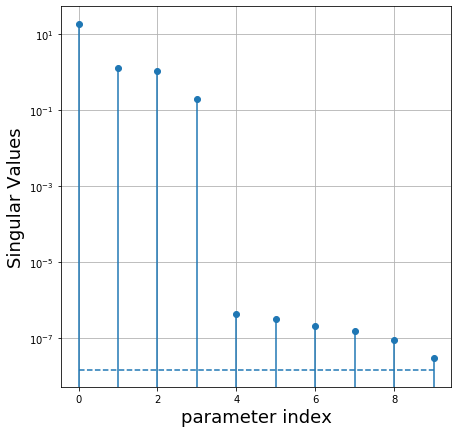

In [28]:
# plot eigenvalues
plt.figure(figsize=(7, 7))
plt.stem(sqrteigs, use_line_collection=True)
plt.plot(np.sqrt(np.finfo(float).eps)*np.ones((m,1)),'--')
plt.xlabel('parameter index', fontsize=18)
plt.ylabel('Singular Values', fontsize=18)
plt.grid(True)
plt.yscale('log')

if r == 1:
    # match the sign
    W[: 0] = np.sign(A.T @ W[:, 0])*W[:, 0]
    # plot first eigenvector and the known ridge direction
    plt.figure(figsize=(7, 7))
    plt.stem(W[:,0], use_line_collection=True)
    plt.scatter(np.linspace(0,m-1,m), A[:, 0], s=150, c ='r', marker = 'o', alpha = 0.25)
    plt.xlabel('parameter index', fontsize=18)
    plt.ylabel('Eig. Vector', fontsize=18)

Having approximated the eigenspaces, we want to visualize the function over the first and second most important directions. This is accomplished by plotting the function over the active coordinates defined as $y = W_r^Tx$ where $W_r = [w_1 \dots w_r]$ for r = 2. In other words, the first set of active coordiantes are $y^1_i = w_1^Tx_i$ and the second set of active coordinates are $y^2_i = w_2^Tx_i$. We refer to the plots of paired data over the subsequent projection to the active coordinates, $\lbrace w_j^Tx_i, f(x_i) \rbrace_{i=1}^N$ for each $j=1,\dots,r$, as *shadow plots*.

We can also *sweep* over this active direction in the original domain partitioning the Euclidean space $\mathbb{R}^m$ into the direct sum,
$$
\mathbb{R}^m = \mathcal{W}_r \oplus \mathcal{W}_r^{\perp},
$$
where $\mathcal{W}_r = \text{span}(w_1,\dots,w_r)$ and $\mathcal{W}_r^{\perp} = \text{span}(w_{r+1},\dots,w_m)$. Of course, there are important considerations to ensure we appropriately restrict to samples of
$$
\lbrace x \in \mathcal{X}\,:\, x = W_ry + W_r^{\perp}z \rbrace
$$
while retaining the chosen measure on $\mathcal{X}$. Such considerations are left for future discussion of existing work. In the meantime, let's simply set the inactive coordinates to zero, i.e., $z = 0$, realizing that we could alternatively pick any $z \in \mathbb{R}^{m-r}$ such that $x \in \mathcal{X}$ (there are infinitely many $z$ to choose from given any fixed $y$ to reconstruct an original parameter value $x$). Then, we can define a 1-dimensional sweep through the origin as
$$
\tilde{f}(t) = f(tw_i)
$$
for all $t \in \mathbb{R}$ (checking that $tw_i \in \mathcal{X}$) to visualize the function along the direction $w_i$ as the corresponding graph,
$$
\lbrace (t, y) \in \mathbb{R}^2 \,:\, y = \tilde{f}(t) \rbrace.
$$
Alternatively, we could generate an *active sweep* at any point in the domain by redefining the function response as
$$
\tilde{f}_{x}(t) = f(x + tw_i).
$$

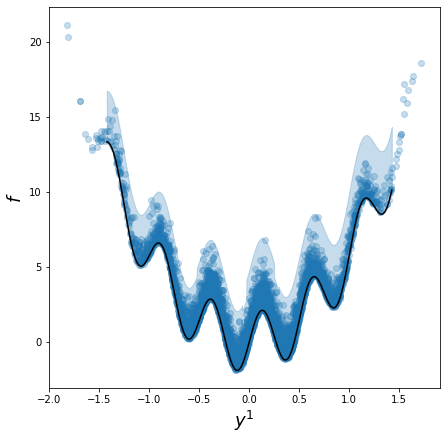

In [29]:
# compute the active coordinates from the data matrix
y1 = X.numpy() @ W[:, 0]
y2 = X.numpy() @ W[:, 1]

# make a shadow plot the data
fig, ax = plt.subplots(figsize=(7, 7))
# 1-dim shadow plot
plt.scatter(X.numpy() @ W[:, 0], F, alpha=0.25)
plt.xlabel('$y^1$', fontsize=18)
plt.ylabel('$f$', fontsize=18)

# make a sweep of the function through the origin in the dominant active direction
tmax = np.reshape(np.linspace(-2*np.sqrt(m), 2*np.sqrt(m), N),(N,1))
Xsweep0 = tmax*W[:, 0].T
# reject parameters violating original bounds
inX0 = (Xsweep0.max(-1) <= 1) & (Xsweep0.min(-1) >= -1) 
tIN = tmax[inX0]
ft0, ftquad, ftsine = func(tf.convert_to_tensor(Xsweep0[inX0, :],dtype=np.float32), A)
# overlay onto shadow plot
plt.plot(tIN, ft0, c='black')

# sweep over the first active direction for each random point sampled in domain
# initialize ftmin and ftmax for visualization of sweeps over ranges
ftmin = ft0.numpy()
ftmax = ft0.numpy()
for i in range(N):
    # build a sweep over the maximum extent possible (active direction is hypercube diagonal)
    Xsweep = np.ones((N,m)) @ np.diag(X.numpy()[i, :]) + tmax*W[:, 0].T
    # reject parameters violating original bounds
    inX = (Xsweep.max(-1) <= 1) & (Xsweep.min(-1) >= -1)
    if inX.any():
        # evaluate sweeps over accepted combinations
        ft, ftquad, ftsine = func(tf.convert_to_tensor(Xsweep[inX, :],dtype=np.float32), A)
        # recompute active coordinates
        t = Xsweep[inX, :] @ W[:, 0]
        # update ftmin and ftmax by interpolating sweep to initial sweep through origin
        inSweep = (tIN >= np.min(t)) & (tIN <= np.max(t))
        int_ft = np.interp(tIN[inSweep].reshape(-1), t, ft.numpy())
        ftmin[inSweep.reshape((-1))] = np.minimum(int_ft, ftmin[inSweep.reshape((-1))])
        ftmax[inSweep.reshape((-1))] = np.maximum(int_ft, ftmax[inSweep.reshape((-1))])

plt.fill_between(tIN.reshape(-1), ftmin, ftmax, alpha=0.25, color='C0')

Additionally, we can sweep over all ordered directions up to the rank $r$ approximation of the eigenspaces of $C$ to define a *fingerprint* of the function. Note that the x-axis now corresponds to the length scales of the *different* ordered orthogonal directions as opposed to a single chosen direction (like above). Notice the decay in the function response with increasing index over these active subspace sweeps through the origin.

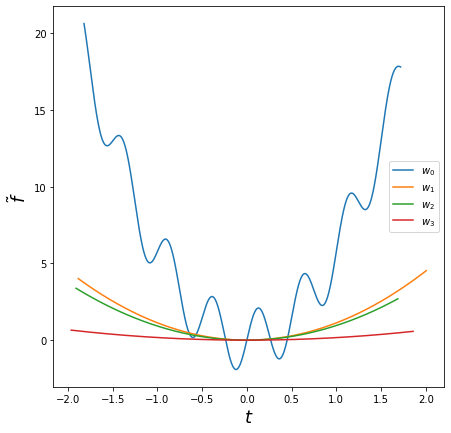

In [30]:
# Visualize the active fingerprint of the function
fig, ax = plt.subplots(figsize=(7, 7))
for j in range(0,r):
    yr = X.numpy() @ W[:, j]
    t = np.reshape(np.linspace(np.min(yr), np.max(yr), N),(N,1))
    Xsweep = t*W[:, j].T
    ft, ftquad, ftsine = func(tf.convert_to_tensor(Xsweep,dtype=np.float32), A)
    plt.plot(t, ft, label='$ w_' + str(j) + '$')
plt.xlabel('$t$', fontsize=18)
ax.set_ylabel(r"$ \tilde{f} $", fontsize=18)
ax.legend()

Lastly, we can further generalize visualizations to make a 2-dimensional shadow plot where the coordinate axes represent the first and second active directions, and the color represents the function response. We can also generalize the notion of a sweep but this requires a *mesh* as opposed to a univariate sweep and the computational complexity will grow exponentially with the subspace dimension $r$. Moreover, instead of restricting $t \in \mathbb{R}$ to closed intervals, we have to restrict $t \in \mathbb{R}^r$ to a compact domain realized as a *zonotope* (the image of the hypercube under the projection serving as the $r$-dimensional compact domain). 

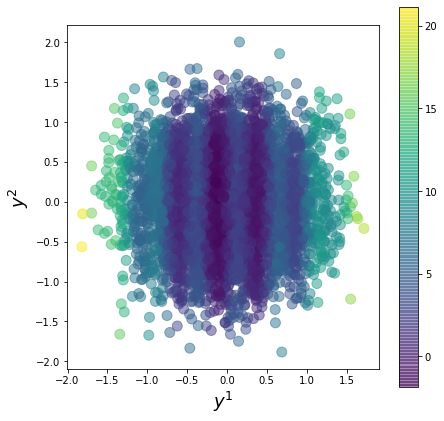

In [31]:
# 2-dim shadow plot
plt.figure(figsize=(7, 7))
plt.scatter(X.numpy() @ W[:, 0], X.numpy() @ W[:, 1], s=100, c=F, alpha=0.5)
plt.xlabel('$y^1$', fontsize=18)
plt.ylabel('$y^2$', fontsize=18)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()